## Data Science Central Challenge: Identifying patterns in complex time series 

### http://www.datasciencecentral.com/forum/topics/challenge-of-the-week-identifying-patterns-in-complex-time-series

#### Solution
"Solution to the 9/26/15 challenge of the week: identifying patterns in complex time series. The data is pageviews for one of our websites. Click here to download a bigger data set, involving multiple websites, page view and session metrics (session is a more reliable metric in this context), for a longer time period. The time series has a weekly periodicity with two peaks: Monday and Thursday, corresponding respectively to the publication of the Monday and Thursday digests. The impact of the Monday and Thursday email blasts extent over the next day; this makes measuring the yield more difficult, unless you use additional data, e.g. from our newsletter vendor. However, the bulk of the impact is really on Monday and Thursday. Some weeks, Wednesday or Friday or even Saturday can be our best day: it usually means that we have published an article that is even more popular than the digests, or that we got featured in a very popular news outlet, or that a bot got undetected by Google Analytics, explaining a spike in pageviews (but not in sessions). When this happens on a Monday or Thursday, it makes for an unusually high peak."

#### How I attempted the problem
I fitted a regression model which accounts for trend and seasonality.

** y = P(t) + S(t) + T(t) + R(t)**
* P(t)~Polynomial component
* S(t)~Seasonal component
* T(t)~Trend component
* R(t)~Residual error


In [748]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import datetime

full=pd.read_csv("DATA/DSC_Time_Series_Challenge.csv",dtype = {'Day ':str,'Sessions':int,'Pageviews':int})
time=[datetime.datetime.strptime(t[0],"%m/%d/%y") for t in full[['Day ']].values]
weekday=[datetime.datetime.strptime(t[0],"%m/%d/%y").isocalendar()[2] for t in full[['Day ']].values]

full['time']=time
full['index']=np.arange(1,len(full)+1)
full['sq_index']=np.power((np.arange(1,len(full)+1)),2)
full['weekday']=weekday

time_component='index'
seasonal_list=['weekday']

full=full.sort_values(by=[time_component])
train=full[:600].copy()


len(train)

600

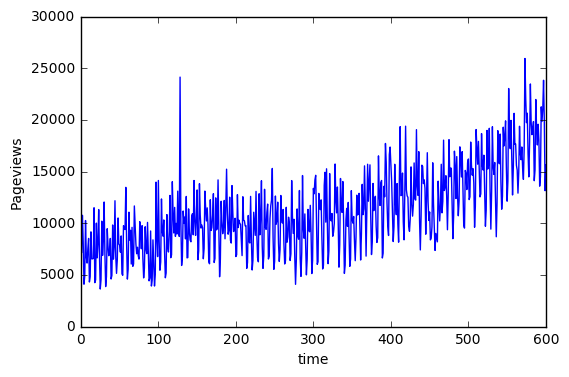

array([0, 1, 2, 3, 4, 5, 6])

In [749]:
time_component='index'

# seasonal_component='weekday'

seasonal_list=['weekday']

for seasonal_component in seasonal_list:
    minsec=min(train[seasonal_component])
    maxsec=max(train[seasonal_component])
    train[seasonal_component]=train[seasonal_component].apply(lambda x: (x - minsec))


plt.plot(train['index'],train['Pageviews'],'-')
plt.xlabel('time')
plt.ylabel('Pageviews')
plt.show()

np.unique(train['weekday'])

## Find seasonal patterns:

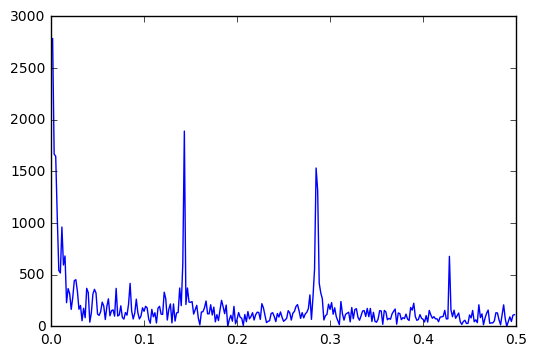

In [750]:
T=3./800 
N=len(train)
tr=[]


yf = np.fft.fft(train['Pageviews'])
freq= np.fft.fftfreq(len(yf))


from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy.fftpack import fftfreq
import matplotlib.pyplot as plt

yf = fft(train['Pageviews'])
freq= fftfreq(len(yf))
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
y_abs=( 2.0/N * np.abs(yf[:N//2]))

plt.plot(freq[1:N//2],2.0/N * np.abs(yf[1:N//2]))
plt.show()


In [751]:
def filter_trend(unfiltered,band,f_signal,threshold):
    filtered=[]
    for x,f in unfiltered:
        if np.absolute(f)>f_signal+band or np.absolute(f)<f_signal-band or (2.0/N *np.abs(x))<=threshold:
            pass
        else:
            filtered.append((f,x))
    return np.array(filtered)
    
n=len(train)
F_unfiltered  = np.column_stack((yf[1:n//2],freq[1:n//2]))
np.absolute(filter_trend(F_unfiltered, 0.299,0.3,1500))

array([[  1.66666667e-03,   8.35641306e+05],
       [  3.33333333e-03,   5.00253580e+05],
       [  5.00000000e-03,   4.94099934e+05],
       [  1.43333333e-01,   5.67160341e+05],
       [  2.85000000e-01,   4.59942544e+05]])

### I found dominant frequencies at .14 and .285 at a cut off magnitude of 1500. These correspond to T=7.14,3.5. There were also some frequencies around the e-3 orders of magnitude. These were at .00166, .00333, and 0.005 and had periods upwards of 200.

## Does it make sense to reuse frequencies for the trend and seasonal components?

* On one hand, it might be better not to miss anything. I doubt there will be a prominant trend for a weekday every 28 weeks.
* For the trend component, it would makes sense to use the highest frequencies in the dependent variable.
* For the seasonal component, there is an "interesting" frequency around .412 that might be included along with noise (a better filtering method could be used in the future)

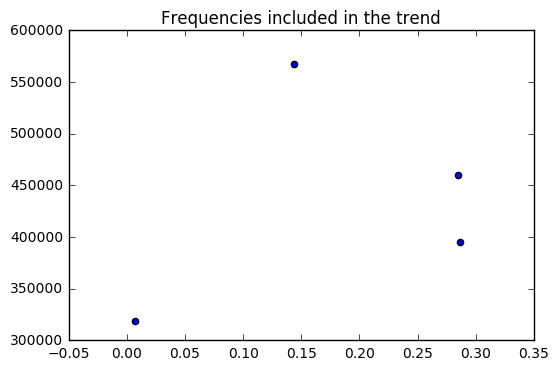

[ 0.00666667  0.14333333  0.285       0.28666667]


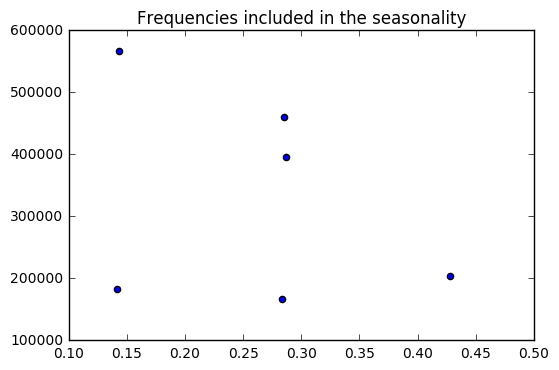

[ 0.14166667  0.14333333  0.28333333  0.285       0.28666667  0.42833333]


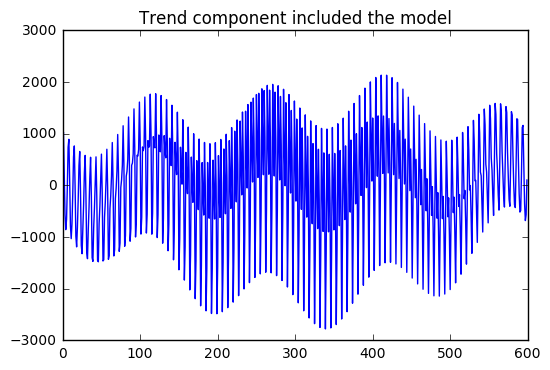

In [752]:
n=len(train)

F_unfiltered  = np.column_stack((yf[1:n//2],freq[1:n//2]))

F_filtered = filter_trend(F_unfiltered, 0.295,0.3,1000)

signal=np.zeros(len(train))
t=np.arange(0,len(train))
t_full=np.arange(0,len(full))
signal_full=np.zeros(len(full))
for i,x in F_filtered:
    magnitude=np.absolute(x)/n
    f=np.absolute(i)
    phase=np.angle(x)
    signal+= magnitude * np.cos(2*np.pi*t*f+phase)
    signal_full+= magnitude * np.cos(2*np.pi*t_full*f+phase)
train['trend']=signal
full['trend']=signal_full

plt.scatter((np.absolute(F_filtered)[:,0]),
        (np.absolute(F_filtered)[:,1]))
plt.title("Frequencies included in the trend")
plt.show()

frequency_components=np.absolute(F_filtered)[:,0]
print(
frequency_components)

F_filtered = filter_trend(F_unfiltered, 0.2,0.3,500)


plt.scatter((np.absolute(F_filtered)[:,0]),
        (np.absolute(F_filtered)[:,1]))
plt.title("Frequencies included in the seasonality")
plt.show()

frequency_components=np.absolute(F_filtered)[:,0]
print(
frequency_components)

plt.plot(t,signal,'-')
plt.title('Trend component included the model')
plt.show()



In [753]:
input_df2=train[seasonal_list]
output=train[['Pageviews']]
y=output.values
input_=input_df2.values
m,n =np.shape(input_)
x=input_
frequency_components=np.absolute(F_filtered)[:,0]
frequency_components = 2*np.pi*np.outer(frequency_components,np.ones(x.shape[1])).reshape((len(frequency_components),x.shape[1]))

trig_args = np.dot(frequency_components,x.T ).T
seasonal_x = np.column_stack((np.sin(trig_args),np.cos(trig_args)))

m,n =np.shape(seasonal_x)
# print(seasonal_x)
x=np.ones((m,n+3))
x[:,1:]=np.column_stack((seasonal_x,train['trend'],train['sq_index']))


A=x.T.dot(x)
b=x.T.dot(y)
z = np.linalg.solve(A,b)

SSE=np.sum((y-x.dot(z))**2)
print("SSE :",SSE)
print("Baseline: ",sum((y-np.mean(y))**2)[0])

SSE : 1944276926.6
Baseline:  9765197379.99


SSE:  1944276926.6
SST:  9765197379.99
R^2:  0.80089732435


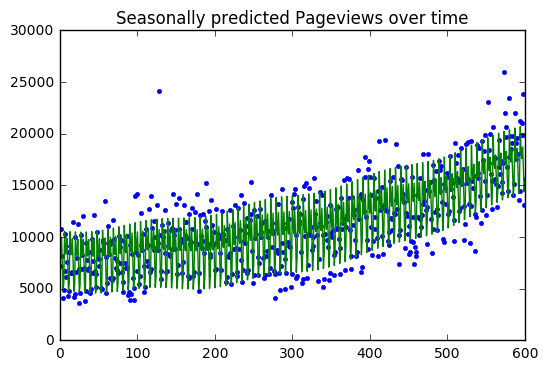

array([[  7.90916346e+03],
       [ -3.43323463e+02],
       [  2.02996737e+03],
       [ -1.27558896e+02],
       [  1.57400072e+03],
       [ -1.50839119e+03],
       [  1.66237302e+02],
       [ -2.57103864e+03],
       [  2.91921259e+03],
       [ -2.56561597e+02],
       [  1.41790642e+03],
       [  7.41643671e+02],
       [  7.09065040e+02],
       [  4.67416150e-01],
       [  2.63619570e-02]])

In [754]:
SSE=np.sum((y-x.dot(z))**2)
SST=sum((y-np.mean(y))**2)[0]
print("SSE: ",SSE)
print("SST: ",SST)
print("R^2: ",1-SSE/SST)


plt.plot(train['index'],y,'.')
plt.plot(train['index'],x.dot(z),'-')
plt.title("Seasonally predicted Pageviews over time")
plt.show()
z

## Which weekdays are the peaks located at? 

In [755]:
peaks=[]
for i,xz in enumerate(x.dot(z)):
    if i>0 and i<len(x.dot(z))-1:
        if x.dot(z)[i]>x.dot(z)[i-1] and x.dot(z)[i]>x.dot(z)[i+1]:
            peaks.append(train['time'][i].isocalendar()[2])
print("peaks: ",np.unique(peaks))


peaks:  [1 4]


## Are the peaks getting smaller over time?

### After accounting for seasonality and trend, the peaks seem to be a little bit smaller.

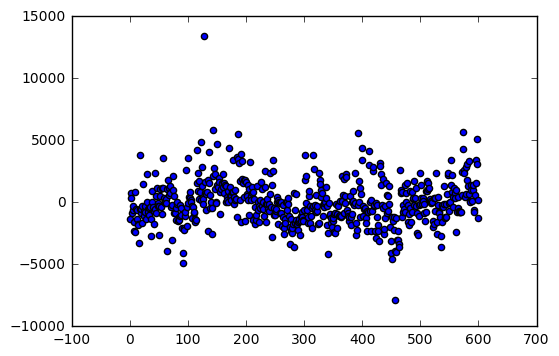

In [756]:
plt.scatter(train['index'],y-x.dot(z))
plt.show()

## The residual plot is not indicative of a major seasonal pattern. There is a slight hump at the begining that levels off and increases slightly toward the end.

SSE:  7912078069.33
SST:  21103815266.6
R^2:  0.625087787712


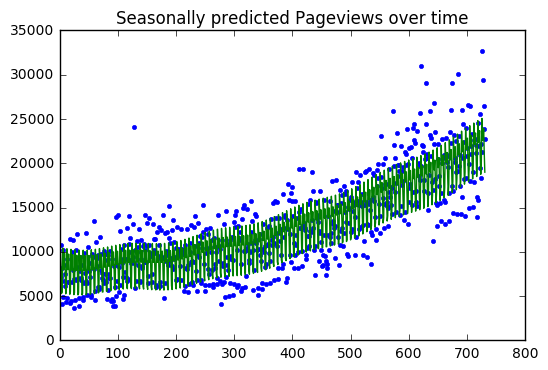

In [757]:
input_df2=full[seasonal_list]
output=full[['Pageviews']]
y=output.values
input_=input_df2.values
m,n =np.shape(input_)
x=input_
frequency_components=np.absolute(F_filtered)[:,0]
frequency_components = 2*np.pi*np.outer(frequency_components,np.ones(x.shape[1])).reshape((len(frequency_components),x.shape[1]))

trig_args = np.dot(frequency_components,x.T ).T
seasonal_x = np.column_stack((np.sin(trig_args),np.cos(trig_args)))

m,n =np.shape(seasonal_x)
# print(seasonal_x)
x=np.ones((m,n+3))
x[:,1:]=np.column_stack((seasonal_x,full['trend'],full['sq_index']))

SSE=np.sum((y-x.dot(z))**2)
SST=sum((y-np.mean(y))**2)[0]
print("SSE: ",SSE)
print("SST: ",SST)
print("R^2: ",1-SSE/SST)

plt.plot(full['index'],full[['Pageviews']],'.')
plt.plot(full['index'],x.dot(z),'-')
plt.title("Seasonally predicted Pageviews over time")
plt.show()



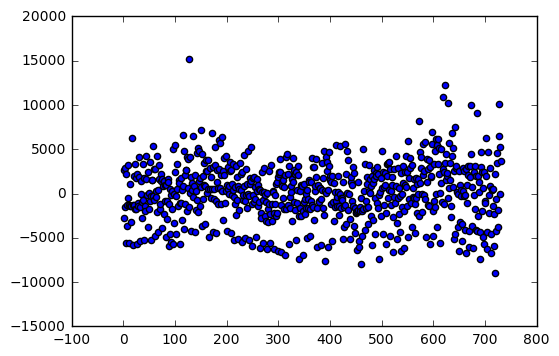

In [758]:
plt.scatter(full['index'],y-x.dot(z))
plt.show()

### There is a slightly overall trend in the residual plot. Including lower frequency components could help stablize errors.